# Part 2.1 - Feature Engineering for XGBoost Model
In this notebook, we will be loading in our data set once again so that we can engineer features based on the statistical properties of the flux and observation times.

In case a slight memory refresher would be useful, let's revist the dataset we are using. Again, you can find more information about it  [here](https://www.kaggle.com/c/PLAsTiCC-2018/data). 

#### The columns in the training set contain the following fields:
- **object_id** [int32]: Unique id that can be used to reference the metadata.
- **mjd** [float64]: the time in Modified Julian Date (MJD) of the observation.
- **passband** [int8]: The specific LSST passband integer, such that u, g, r, i, z, Y = 0, 1, 2, 3, 4, 5 in which it was viewed.
- **flux** [float32]: the measured flux (brightness) in the passband of observation as listed in the passband column.
- **flux_err** [float32]: the uncertainty on the measurement of the flux listed above.
- **detected** [boolean]: If 1, the object's brightness is significantly different at the 3-sigma level relative to the reference template. Only objects with at least 2 detections are included in the dataset.

The first thing we can do is pin our GPU-based computations to a specific GPU. The `GPU_id` can be changed in order to use a different GPU. The instance in this tutorial uses 2x P40 GPUs, so you should be able to set `GPU_id` to `0` or `1`

In [1]:
import os
GPU_id = 1
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [3]:
import cudf as gd
import pandas as pd
import numpy as np
import math
import seaborn as sns
from termcolor import colored
from cudf_workaround import cudf_groupby_aggs
import matplotlib.pyplot as plt
import warnings

from utils import scatter, groupby_aggs

ModuleNotFoundError: No module named 'cudf'

In [27]:
warnings.filterwarnings("ignore")
sns.set()
print(gd.__version__)

0.9.0a+1267.gd69c846.dirty


<a id="global"></a>
## Global variables 

Here's the path to the dataset. *This is on a shared drive*

In [28]:
PATH = '/home/cjnolet/workspace/notebooks-extended/competition_notebooks/kaggle/plasticc/data'

We will be using Nvidia P40 cards for this tutorial, which have 24gb of memory. Our test set contains the most data, with over 19gb. In order to fit this on a single device, we will be subsampling from out test set. 

<a id="etl"></a>
## ETL & Visualizations

### Load data for ETL part 1
**GPU load data**

The first thing we will need to do is load the CSV files for our training and test datasets into cuDF DataFrames.

In [31]:
def load_train_test_csv(path):
    """
    Loads the CSV files for the test & train datasets into cuDFs
    """
    
    ts_cols = ['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'detected']
    ts_dtypes = ['int32', 'float32', 'int32', 'float32','float32','int32']
    
    train_gd = gd.read_csv('%s/training_set.csv'%PATH, names=ts_cols,dtype=ts_dtypes,skiprows=1)
    test_gd = gd.read_csv('%s/test_set_minimal.csv'%PATH, names=ts_cols,dtype=ts_dtypes,skiprows=1)
    
    return train_gd, test_gd

In [32]:
train_gd, test_gd = load_train_test_csv(PATH)

Let's look at the contents of the first row

In [33]:
test_gd.head().to_pandas()

,object_id,mjd,passband,flux,flux_err,detected
0,49433749,60497.242188,3,0.023640,5.446583,0
1,49433749,60498.296875,3,-3.182177,5.523324,0
2,49433749,60499.234375,0,-6.291367,11.763515,0
3,49433749,60502.230469,2,-0.587693,2.001535,0
4,49433749,60506.269531,3,-4.349967,5.440668,0


### Visualizations

Let's visualize the flux for different passbands at different times for a few different objects in our data set.

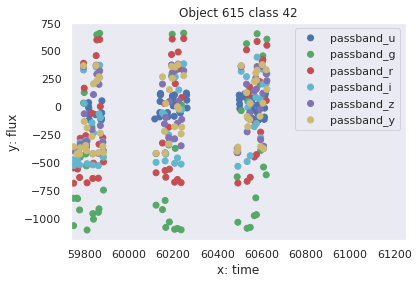

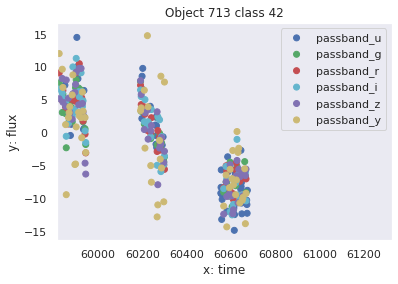

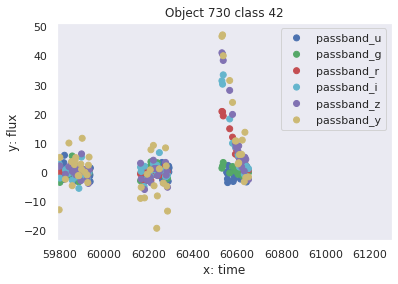

In [34]:
n_objects = 3

for idx, oid in zip(range(n_objects), train_gd.object_id.unique()[:n_objects]):
    train = train_gd.to_pandas()
    mask = train.object_id== oid

    scatter(train.loc[mask,'mjd'].values,
            train.loc[mask,'flux'].values,
            values=train.loc[mask,'passband'].values,
            xlabel='time',
            ylabel='flux',
            title='Object %d class 42'%oid)
    plt.show()

### Perform ETL Pt 1 - Compute flux skewness for each object_id

To begin our ETL, we are going to compue the skewness across the flux for all times and sort the resulting dataframes by their ids. 

In [35]:
test_gd = test_gd[['object_id','flux']]
train_gd = train_gd[['object_id','flux']]

In [36]:
aggs = {'flux':['skew']}

test_gd = cudf_groupby_aggs(test_gd,group_id_col='object_id',aggs=aggs)
train_gd = cudf_groupby_aggs(train_gd,group_id_col='object_id',aggs=aggs)

In [37]:
test_flux_skew_gd = test_gd.sort_values(by='object_id')
train_flux_skew_gd = train_gd.sort_values(by='object_id')

Let's print out the first row of the aggregated dataframe

In [38]:
train_flux_skew_gd.head().to_pandas()

,object_id,skew_flux
0,615,-0.349541
1,713,0.014989
2,730,3.177856
3,745,4.979831
4,1124,4.406288


### Perform ETL Pt 2 - Flux & timestamp summary statistics

We computed the flux skew in the previous ETL step and only kept those columns on GPU. Next we will need to load our original train & test CSV files back in so that we can do some additional aggregations.

In [39]:
train_gd, test_gd = load_train_test_csv(PATH)

Read in the training metadata fields

In [40]:
cols = ['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf',
       'hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err', 
       'distmod','mwebv', 'target']

dtypes = ['int32']+['float32']*4+['int32']+['float32']*5+['int32']

train_meta_gd = gd.read_csv('%s/training_set_metadata.csv'%PATH, names=cols, dtype=dtypes, skiprows=1)

In [41]:
train_meta_gd.head().to_pandas()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046082,-61.943840,320.796539,-51.753708,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085941,-27.784407,223.525528,-54.460751,1,1.8181,1.6267,0.2552,45.406303,0.007,88
2,730,33.574219,-6.579593,170.455582,-61.548218,1,0.2320,0.2262,0.0157,40.256100,0.021,42
3,745,0.189873,-45.586655,328.254456,-68.969299,1,0.3037,0.2813,1.1523,40.795101,0.007,90
4,1124,352.711304,-63.823654,316.922302,-51.059402,1,0.1934,0.2415,0.0176,40.416599,0.024,90


And the resulting testing metadata fields, excluding the `target` label field

In [42]:
# # Remove the target field from the cols 
del cols[-1],dtypes[-1]

test_meta_gd = gd.read_csv('%s/test_set_metadata.csv'%PATH, names=cols,dtype=dtypes,skiprows=1)

In [43]:
def etl_gpu(df,df_meta):
    
    aggs = {
        'passband': ['mean'],  # mean passband
        'detected': ['mean'],  # mean detected
        'mjd':['max','min'],   # min / max time range
    }
    
    agg_df = groupby_aggs(df, aggs)
    
    # If flux uncertanty is low, we get a high ratio squared. If the uncertainty is high, 
    # we will get a low ratio squared.
    df['flux_ratio_sq'] = df['flux'] / df['flux_err']
    df['flux_ratio_sq'] = df['flux_ratio_sq'].applymap(lambda x: math.pow(x,2))
    
    # Multiply flux by the ratio squared
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    
    aggs2 = {
        'flux_ratio_sq':['sum'],            # Sum the sq flux ratios
        'flux_by_flux_ratio_sq':['sum'],    # Sum the flux * sq flux ratios
        'flux': ['min', 'max', 'mean'],     # Summary stats for flux
        'flux_err': ['min', 'max', 'mean'], # Summary stats for flux certainty
    }
    
    agg_df2 = groupby_aggs(df, aggs2)
    agg_df = agg_df.merge(agg_df2,on=['object_id'],how='left')
    del agg_df2

    agg_df['flux_diff'] = agg_df['max_flux'] - agg_df['min_flux']
    agg_df['flux_dif2'] = (agg_df['max_flux'] - agg_df['min_flux']) / agg_df['mean_flux']
    
    agg_df['flux_w_mean'] = agg_df['sum_flux_by_flux_ratio_sq'] / agg_df['sum_flux_ratio_sq']
    agg_df['flux_dif3'] = (agg_df['max_flux'] - agg_df['min_flux']) / agg_df['flux_w_mean']
    
    agg_df['mjd_diff'] = agg_df['max_mjd'] - agg_df['min_mjd']
    agg_df.drop_column('max_mjd')
    agg_df.drop_column('min_mjd')
    
    for col in ['ra','decl','gal_l','gal_b']:
        df_meta.drop_column(col)
    
    df_meta = df_meta.merge(agg_df,on=['object_id'],how='left')
    return df_meta

In [44]:
train_final_gd = etl_gpu(train_gd,train_meta_gd)
train_final_gd = train_final_gd.merge(train_flux_skew_gd,on=['object_id'],how='left')

In [45]:
test_final_gd = etl_gpu(test_gd,test_meta_gd)
del test_gd,test_meta_gd
test_final_gd = test_final_gd.merge(test_flux_skew_gd,on=['object_id'],how='left')

In [46]:
train_final_gd.head().to_pandas()

,object_id,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,mean_passband,mean_detected,...,mean_flux,min_flux_err,max_flux_err,mean_flux_err,flux_diff,flux_dif2,flux_w_mean,flux_dif3,mjd_diff,skew_flux
0,278971,1,0.2775,0.6479,0.3814,42.941902,0.011,90,2.378917,0.037037,...,0.968376,0.574151,56.167137,2.568087,146.038605,150.807755,6.697439,21.805141,853.707031,-5.270295
1,279158,1,0.6597,0.6066,0.0373,42.767803,0.017,90,2.336364,0.051515,...,2.152888,0.688833,11.235345,2.453753,71.678596,33.294153,43.607445,1.643724,853.847656,4.089486
2,279243,1,0.8880,0.8933,0.0291,43.797501,0.013,88,2.378917,0.615385,...,-15.134775,1.125018,57.165867,3.258343,162.290894,-10.723046,-15.830821,-10.251577,853.707031,0.740220
3,279292,1,0.3048,0.3106,0.0087,41.042198,0.028,15,2.647059,0.247059,...,25.214522,0.728015,63.030613,3.031211,298.320587,11.831300,179.781052,1.659355,854.652344,2.623070
4,279402,1,0.3550,0.5820,0.3428,42.658596,0.016,90,2.647059,0.274510,...,23.327405,0.708740,62.219566,2.937566,259.043427,11.104683,164.181549,1.577786,854.652344,2.454265


### Merge in Bottleneck Features

Load the bottleneck features from `Part 1.2` and merge with `flux` & `mjd` statistical features. At this point, the notebook from `Part 1.2` should have been executed end-to-end. 

In [47]:
train_bn = gd.from_pandas(pd.read_pickle('train_bn.pkl'))
train_bn['object_id'] = train_bn['object_id'].astype('int32')
train_final_gd = train_final_gd.merge(train_bn,on=['object_id'],how='left')

In [48]:
test_bn = gd.from_pandas(pd.read_pickle('test_bn.pkl'))
test_bn['object_id'] = test_bn['object_id'].astype('int32')
test_final_gd = test_final_gd.merge(test_bn,on=['object_id'],how='left')

del train_bn,test_bn  # Save device memory

In [49]:
train_final_gd.head().to_pandas()

,object_id,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,mean_passband,mean_detected,...,bottleneck6,bottleneck7,bottleneck8,bottleneck9,bottleneck10,bottleneck11,bottleneck12,bottleneck13,bottleneck14,bottleneck15
0,278971,1,0.2775,0.6479,0.3814,42.941902,0.011,90,2.378917,0.037037,...,17.006578,5.721367,5.553925,3.860260,2.370861,2.146526,2.967228,0.087809,4.513912,4.389868
1,279158,1,0.6597,0.6066,0.0373,42.767803,0.017,90,2.336364,0.051515,...,18.194212,3.973279,7.927842,1.085304,0.914327,3.720223,1.001722,0.262647,4.044074,3.766971
2,279243,1,0.8880,0.8933,0.0291,43.797501,0.013,88,2.378917,0.615385,...,3.693534,12.467365,4.456998,2.535072,0.943642,0.000000,9.945712,2.041474,10.028579,20.917561
3,279292,1,0.3048,0.3106,0.0087,41.042198,0.028,15,2.647059,0.247059,...,6.256434,12.600988,5.467937,0.100083,2.807478,0.426396,4.797625,0.109070,0.435448,6.384472
4,279402,1,0.3550,0.5820,0.3428,42.658596,0.016,90,2.647059,0.274510,...,22.337191,5.423245,9.086507,2.625529,0.814411,5.758591,9.373267,0.217976,20.138351,5.450137


### Store Final Train/Test Data to Disk

Store our extracted data out to csv files so that we can use it downstream 

In [50]:
train_final_gd.to_pandas().to_pickle("train_gdf.pkl")
test_final_gd.to_pandas().to_pickle("test_gdf.pkl")